In [1]:
import gpytorch
import torch
import matplotlib.pyplot as plt

from botorch.models import SingleTaskGP
from botorch.optim.fit import fit_gpytorch_scipy
from gpytorch.mlls import ExactMarginalLogLikelihood

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
train_x = torch.sort(torch.rand(20, 1),0)[0]
train_y = torch.sin(6 * train_x - 1.).view(-1)

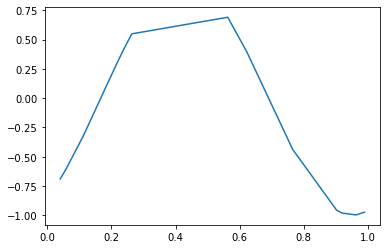

In [3]:
plt.plot(train_x, train_y)

In [4]:
model = SingleTaskGP(train_x, train_y.view(-1,1), covar_module=gpytorch.kernels.RBFKernel())
fit_gpytorch_scipy(ExactMarginalLogLikelihood(model.likelihood, model));

kernel = model.covar_module
noise = model.likelihood.noise
print(noise)

Parameter containing:
tensor([0.0001], requires_grad=True)


In [5]:
def titsias_objective(Z):
    kmm = kernel(Z)
    kmn = kernel(Z, train_x)
    inner_mat = kmn.t() @ (kmm.inv_matmul(kmn.evaluate()))
    larger_sigma = (inner_mat) + noise * torch.eye(inner_mat.shape[-2])
    
    #invquad, logdet = larger_sigma.inv_quad_logdet(train_y, logdet=True)
    trace_term = inner_mat.diag().sum() / (2. * noise)
    train_dist = gpytorch.distributions.MultivariateNormal(torch.zeros_like(train_y), larger_sigma)
    logprob = train_dist.log_prob(train_y).sum()
    return (logprob - trace_term) / train_y.shape[0]
    

In [6]:
inducing_points = torch.rand(8, 1, requires_grad = True)

In [7]:
optimizer = torch.optim.Adam([inducing_points], lr = 1e-3)

In [8]:
old = 1e10
loss = 0.
for i in range(5000):
    loss = -titsias_objective(inducing_points)
    loss.backward()
    optimizer.step()
    if i % 150 == 0:
        print(loss.item())
    if old < loss:
        break
    old = loss

4997.53328562513
4915.7574096150165
4038.613394440021


Text(0, 0.5, 'f(x)')

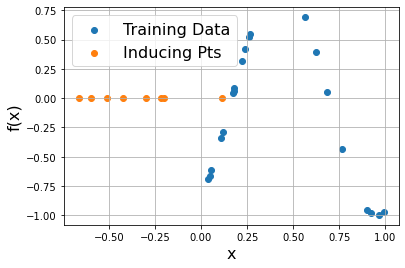

In [9]:
plt.scatter(train_x, train_y, label = "Training Data")
plt.scatter(inducing_points.detach(), torch.zeros(8), label = "Inducing Pts")
plt.legend(fontsize = 16)
plt.grid()
plt.xlabel("x", fontsize = 16)
plt.ylabel("f(x)", fontsize = 16)

In [10]:
## lets look at the posterior variance then??

In [11]:
theoretical_points = torch.linspace(-3., 3.)

kfx = kernel(theoretical_points, train_x)
kxx = kernel(train_x)

In [12]:
posterior_variance = 1. - (kxx.add_jitter(noise)).inv_quad(kfx.t().evaluate(), reduce_inv_quad=False).detach()

/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/lazy/lazy_tensor.py:723: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diag = torch.tensor(jitter_val, dtype=self.dtype, device=self.device)


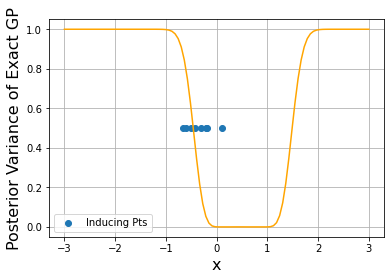

In [13]:
plt.plot(theoretical_points, posterior_variance, color = "orange")
plt.scatter(inducing_points.detach(), 0.5 * torch.ones(8), label = "Inducing Pts")
plt.xlabel("x", fontsize = 16)
plt.ylabel("Posterior Variance of Exact GP", fontsize =16)
plt.legend()
plt.grid()

In [14]:
## so unconstrained optimization of inducing points will tend to push them away from the training data

In [15]:
## lets try optimization again, but constraining the inducing points in a boundary

In [16]:
def delta_svgp_pred_var(new_x, fant_x, train_x, inducing, noise):
    kuu = kernel(inducing)
    knu = kernel(new_x, inducing)
    kux = kernel(inducing, train_x)
    kfu = kernel(fant_x, inducing)
    
    sigma_inv = kuu + kux @ kux.t() * (1. / noise)
    
    denom = sigma_inv.inv_quad(kfu.t().evaluate()) + noise
    numer = (kfu @ sigma_inv.inv_matmul(knu.t().evaluate()))**2
    return -numer / denom

In [17]:
def delta_exact_pred_var(new_x, fant_x, train_x, noise):
    knx = kernel(new_x, train_x)
    kxx = kernel(train_x)
    old_pred_var = 1 - knx @ (kxx.add_jitter(noise).inv_matmul(knx.t().evaluate()))
                                     
    new_train_x = torch.cat((train_x, fant_x), dim=0)
    kxx_fant = kernel(new_train_x)
    knx_fant = kernel(new_x, new_train_x)
    new_pred_var = 1 - knx_fant @ (kxx_fant.add_jitter(noise).inv_matmul(knx_fant.t().evaluate()))
    
    return new_pred_var - old_pred_var

In [18]:
off_point = 1.5 * torch.ones(1, 1)
on_point = 0.5 * torch.ones(1, 1)
query_range = torch.linspace(-2., 2.)

induc_points = torch.rand(8, 1)

svgp_off_data = torch.tensor([delta_svgp_pred_var(
    off_point, 
    fant.view(-1,1), 
    train_x, 
    induc_points,
    noise
) for fant in query_range])

svgp_on_data = torch.tensor([delta_svgp_pred_var(
    on_point, 
    fant.view(-1,1), 
    train_x, 
    induc_points,
    noise
) for fant in query_range])

In [19]:
exact_off_data = torch.tensor([delta_exact_pred_var(
    off_point, 
    fant.view(-1,1), 
    train_x, 
    noise
) for fant in query_range])

exact_on_data = torch.tensor([delta_exact_pred_var(
    on_point, 
    fant.view(-1,1), 
    train_x, 
    noise
) for fant in query_range])

/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/lazy/lazy_tensor.py:723: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diag = torch.tensor(jitter_val, dtype=self.dtype, device=self.device)


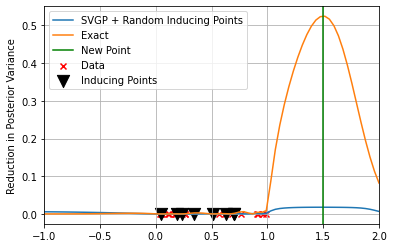

In [20]:
plt.plot(query_range, -svgp_off_data, label = "SVGP + Random Inducing Points")
plt.plot(query_range, -exact_off_data, label = "Exact")
plt.scatter(train_x, torch.zeros(20, 1), color = "red", marker = "x", label = "Data")
plt.scatter(induc_points, torch.zeros(8, 1), color = "black", marker = "v", label = "Inducing Points",
           s=150)
plt.axvline(1.5, color = "green", label = "New Point")
plt.ylabel("Reduction in Posterior Variance")
plt.xlim((-1., 2.0))
plt.legend()
plt.grid()

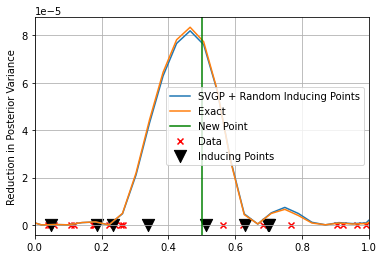

In [30]:
plt.plot(query_range, -svgp_on_data, label = "SVGP + Random Inducing Points")
plt.plot(query_range, -exact_on_data, label = "Exact")
plt.scatter(train_x, torch.zeros(20, 1), color = "red", marker = "x", label = "Data")
plt.scatter(induc_points, torch.zeros(8, 1), color = "black", marker = "v", label = "Inducing Points",
           s=150)
plt.axvline(0.5, color = "green", label = "New Point")
plt.ylabel("Reduction in Posterior Variance")
plt.xlim((0., 1.))
plt.legend()
plt.grid()

In [22]:
## lets train the inducing inputs now instead

In [23]:
class StandardApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = model.mean_module
        self.covar_module = model.covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



In [61]:
vargp_model = StandardApproximateGP(torch.linspace(0., 1., 500).view(-1,1))
likelihood = model.likelihood
mll = gpytorch.mlls.VariationalELBO(likelihood, vargp_model, num_data=train_y.numel())

In [62]:
optimizer = torch.optim.Adam([vargp_model.variational_strategy.inducing_points] +\
                [vargp_model.variational_strategy._variational_distribution.variational_mean] + \
                [vargp_model.variational_strategy._variational_distribution.chol_variational_covar], lr=0.01)

In [63]:
old = 1e10
loss = 0.
for i in range(5000):
    loss = -mll(vargp_model(train_x), train_y.view(-1))
    loss.backward()
    optimizer.step()
    if i % 5 == 0:
        print(loss.item(), vargp_model.variational_strategy.inducing_points.norm())
    if old < loss:
        print(old, loss)
        break
    old = loss

6577.71673027073 tensor(12.9225, grad_fn=<NormBackward0>)
tensor(6577.7167, grad_fn=<NegBackward>) tensor(8124.3476, grad_fn=<NegBackward>)


In [64]:
optimized_inducing_points = vargp_model.variational_strategy.inducing_points

In [65]:
opsvgp_off_data = torch.tensor([delta_svgp_pred_var(
    off_point, 
    fant.view(-1,1), 
    train_x, 
    optimized_inducing_points,
    noise
) for fant in query_range])

opsvgp_on_data = torch.tensor([delta_svgp_pred_var(
    on_point, 
    fant.view(-1,1), 
    train_x, 
    optimized_inducing_points,
    noise
) for fant in query_range])

/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


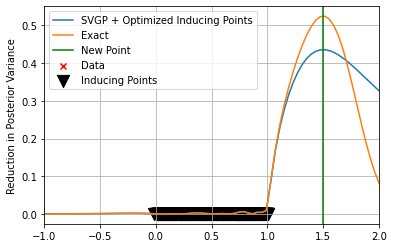

In [66]:
plt.plot(query_range, -opsvgp_off_data, label = "SVGP + Optimized Inducing Points")
plt.plot(query_range, -exact_off_data, label = "Exact")
plt.scatter(train_x, torch.zeros(20, 1), color = "red", marker = "x", label = "Data")
plt.scatter(optimized_inducing_points.detach(), 
            torch.zeros(optimized_inducing_points.shape[0], 1), 
            color = "black", marker = "v", label = "Inducing Points",
           s=150)
plt.axvline(1.5, color = "green", label = "New Point")
plt.ylabel("Reduction in Posterior Variance")
plt.xlim((-1., 2.0))
plt.legend()
plt.grid()

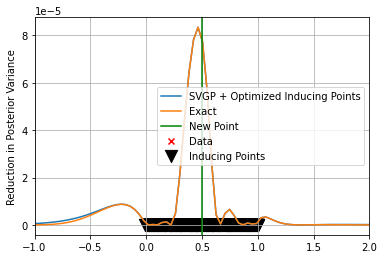

In [67]:
plt.plot(query_range, -opsvgp_on_data, label = "SVGP + Optimized Inducing Points")
plt.plot(query_range, -exact_on_data, label = "Exact")
plt.scatter(train_x, torch.zeros(20, 1), color = "red", marker = "x", label = "Data")
plt.scatter(optimized_inducing_points.detach(), 
            torch.zeros(optimized_inducing_points.shape[0], 1), 
            color = "black", marker = "v", label = "Inducing Points",
           s=150)
plt.axvline(0.5, color = "green", label = "New Point")
plt.ylabel("Reduction in Posterior Variance")
plt.xlim((-1., 2.0))
plt.legend()
plt.grid()